In [1]:
# Imports
import torch
from torch import nn # neural network components
import matplotlib.pyplot as plt # visualisation
import numpy as np
from PlotPredictions import plot_predictions

In [2]:
# Device agnostic
# use GPU if available
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device '{device}'")

0
Using device 'cpu'


In [3]:
# known data from linear regression formula
weight = 0.7
bias = 0.3

start = 0
end = 1 # larger data set
step = 0.01
X = torch.arange(start, end, step).unsqueeze(dim=1) # why unsqueeze? to make it a column?
# y = m X + C
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

In [4]:
# constants
learning_rate = 0.0001
test_split_percentage = 0.80
epochs = 15000 # hyperparameter - we set it ourselves


X_train:80, y_train:80, X_test:20, y_test:20


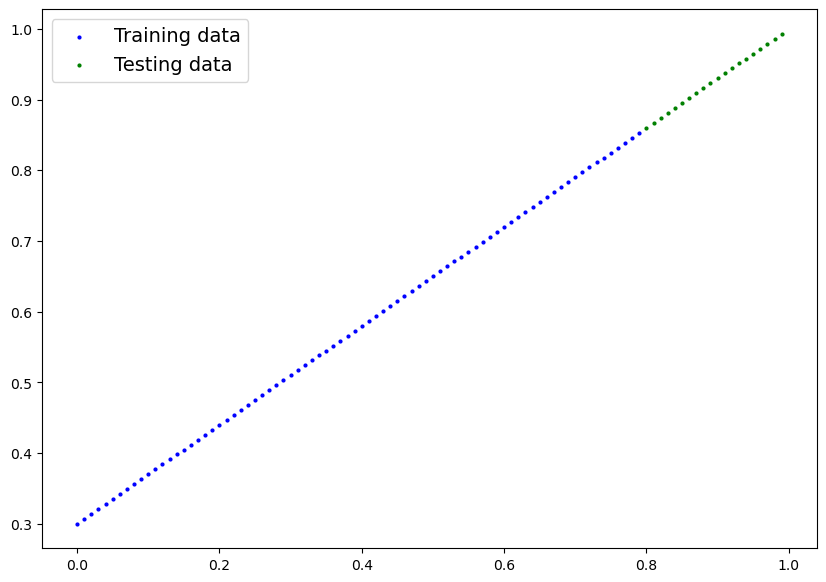

In [5]:
# Split data into Training and Test sets 80/20 split

train_split = int(test_split_percentage * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(f"X_train:{len(X_train)}, y_train:{len(y_train)}, X_test:{len(X_test)}, y_test:{len(y_test)}")

plot_predictions(X_train, y_train, X_test, y_test)

In [6]:
from torch import nn

# Linear Model V2
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor):
        return self.linear_layer(x)


In [7]:
# Create instance of model with random initial state

torch.manual_seed(42) # manual_seed makes random numbers deterministic

model_0 = LinearRegressionModelV2()
list(model_0.parameters())

[Parameter containing:
 tensor([[0.7645]], requires_grad=True),
 Parameter containing:
 tensor([0.8300], requires_grad=True)]

In [8]:
# set target device
next(model_0.parameters()).device

device(type='cpu')

In [9]:
# Load model onto device
model_0.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

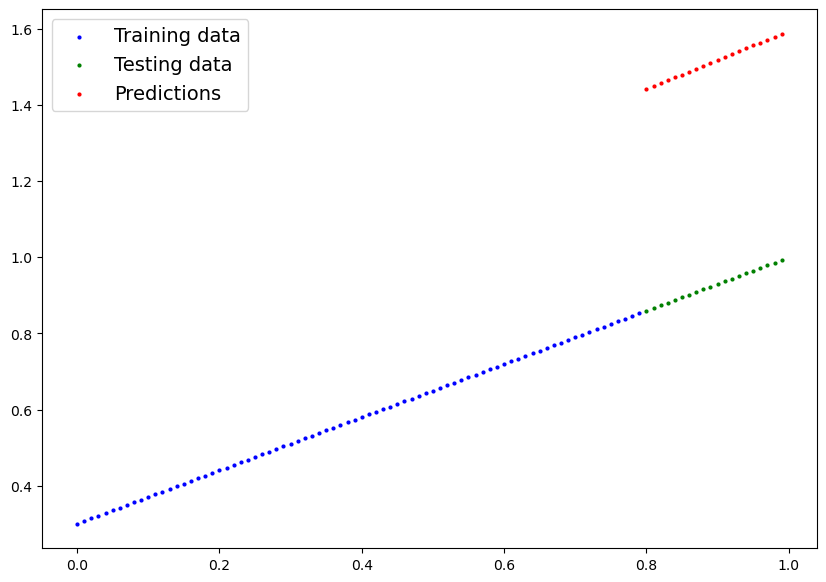

In [10]:
# Run prediction with untrained model
with torch.inference_mode():
    y_preds = model_0(X_test)

# display prediction
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

In [11]:
# set up loss function
loss_fn = nn.L1Loss()

# set up optimiser - stochastic gradient descent - starts randomly then adjusts gradually
# optimiser knows about the model parameters on which it will operate
optimiser_fn = torch.optim.SGD(params=model_0.parameters(),lr = learning_rate) # lr = learning rate, most important hyperparameter

In [12]:
# Training loop and testing loop

# track values during training
epoch_count = []
loss_values = []
test_loss_values = []

X_train.to(device)
y_train.to(device)
X_test.to(device)
y_test.to(device)

for epoch in range(epochs):
    epoch_count.append(epoch)
    model_0.train() # train mode in pytorch set
    
    # forward pass
    y_pred = model_0(X_train)

    # calculate loss (input, target)
    loss = loss_fn(y_pred, y_train)
    loss_values.append(loss)
    
    # optimiser zero grad
    optimiser_fn.zero_grad()
    
    # perform back propogation
    loss.backward()
    
    # step the optimizer
    optimiser_fn.step()
    
    # Testing against the test data
    model_0.eval()
    # inference mode turns off gradient tracking
    with torch.inference_mode():

        # forward pass
        test_pred = model_0(X_test)
        # calculate the loss value
        test_loss = loss_fn(test_pred, y_test)
        test_loss_values.append(test_loss)

    if epoch % 5000 == 0:    
        print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")
        

Epoch: 0 | Test: 0.5555006265640259 | Test loss: 0.5876345038414001
Epoch: 5000 | Test: 0.024474037811160088 | Test loss: 0.045128047466278076
Epoch: 10000 | Test: 0.006521488539874554 | Test loss: 0.015419766306877136


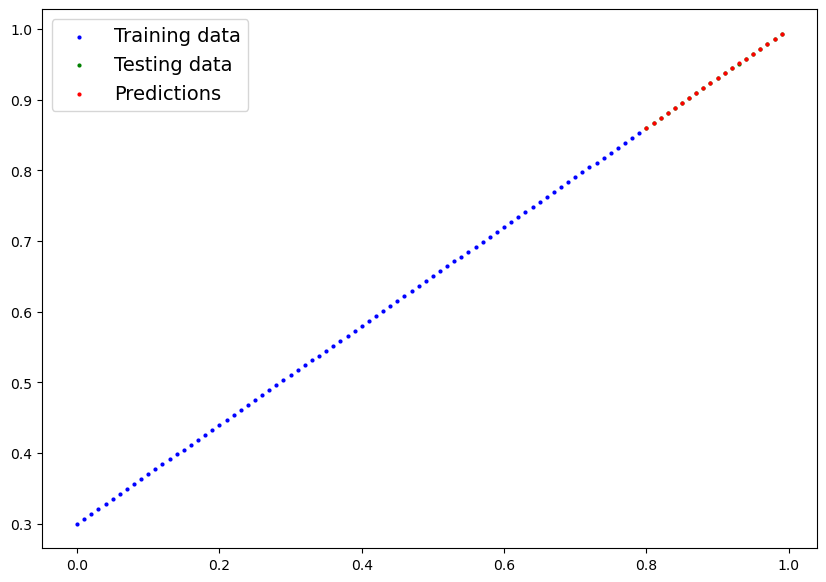

In [13]:
# Run predictions using trained model
model_0.eval()
# inference mode turns off gradient tracking, Performance improvements
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(X_train, y_train, X_test, y_test, y_preds)

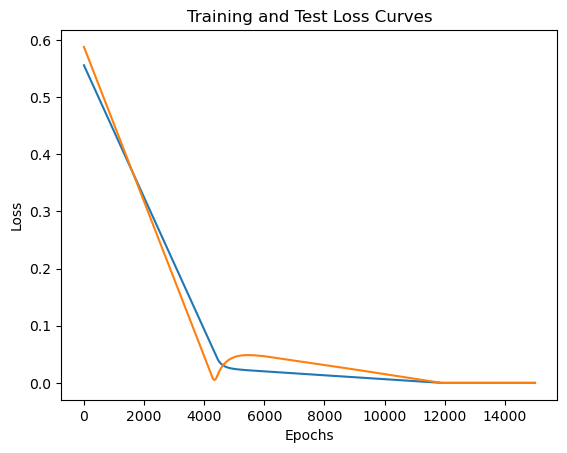

In [14]:
# Plot the outputs of the loss function
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.show()

In [17]:
model_0.state_dict
weight, bias

(0.7, 0.3)